In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Info

In [3]:
data_ori = pd.read_csv('speed_6005.csv', parse_dates=['timestamp'], infer_datetime_format=True)
#data_ori['doy'] = data_ori.Date.apply(lambda t:t.dayofyear)
data_ori.sample(3)
#data_ori

,timestamp,value
2360,2015-09-17 04:50:00,73
82,2015-09-01 08:50:00,87
65,2015-09-01 07:10:00,81


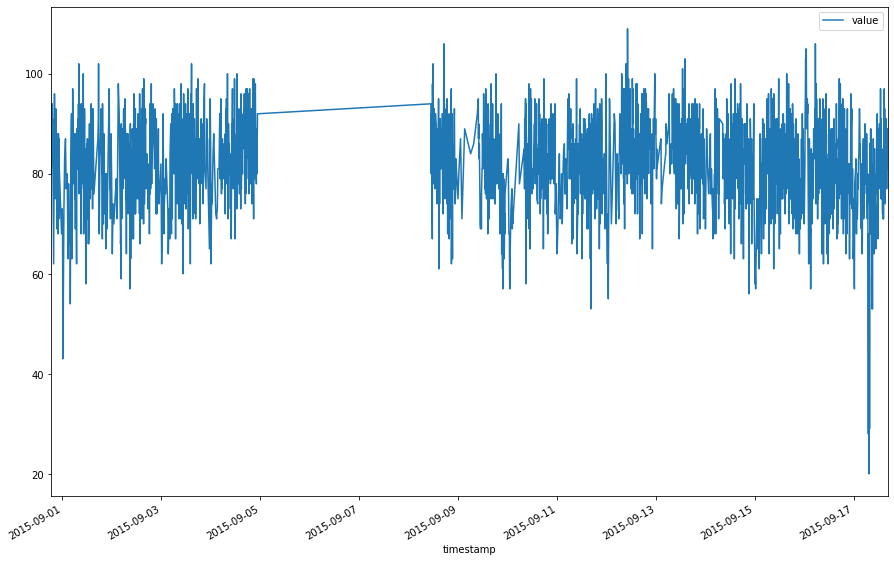

In [4]:
data_ori.plot(x='timestamp', figsize=(15,10))

# Data Processing

In [5]:
data = pd.DataFrame()
data['value'] = data_ori.value
data['time'] = data_ori.timestamp.apply(lambda t:t.time())
data['date'] = data_ori.timestamp.apply(lambda t:t.date())
data.sample(3)

,value,time,date
1420,86,20:46:00,2015-09-12
1391,88,17:31:00,2015-09-12
1547,81,16:38:00,2015-09-13


In [6]:
data_pre = pd.DataFrame()
data_pre['value'] = data_ori.value
data_pre['month'] = data_ori.timestamp.apply(lambda t:t.month)
data_pre['day'] = data_ori.timestamp.apply(lambda t:t.day)
data_pre['hour'] = data_ori.timestamp.apply(lambda t:t.hour)
data_pre['minute'] = data_ori.timestamp.apply(lambda t:t.minute)
data_pre.sample(3)

,value,month,day,hour,minute
546,84,9,4,5,47
2188,83,9,16,12,14
877,92,9,9,19,18


# Anomaly Detection

# Isolation Forest

In [7]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100)
clf.fit(data_pre)

# predictions
y_pred_train = clf.predict(data_pre)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [8]:
print("outliers:", list(y_pred_train).count(-1))

outliers: 250


In [9]:
data_pre['timestamp_int'] = data_ori.timestamp.apply(lambda t:t.timestamp())
data_pre['timestamp'] = data_ori.timestamp
#data_pre['timestamp'] = data_ori['timestamp'].timestamp()
data_pre['normal'] = y_pred_train
data_pre.sample(3)

,value,month,day,hour,minute,timestamp_int,timestamp,normal
152,88,9,1,20,10,1.441138e+09,2015-09-01 20:10:00,1
1030,90,9,10,19,47,1.441914e+09,2015-09-10 19:47:00,1
2150,95,9,16,8,54,1.442394e+09,2015-09-16 08:54:00,1


In [10]:
data_pre[40:60]

,value,month,day,hour,minute,timestamp_int,timestamp,normal
40,82,9,1,4,7,1.441080e+09,2015-09-01 04:07:00,1
41,90,9,1,4,22,1.441081e+09,2015-09-01 04:22:00,1
42,92,9,1,4,27,1.441082e+09,2015-09-01 04:27:00,1
43,63,9,1,4,37,1.441082e+09,2015-09-01 04:37:00,-1
44,69,9,1,4,52,1.441083e+09,2015-09-01 04:52:00,-1
45,97,9,1,5,2,1.441084e+09,2015-09-01 05:02:00,-1
46,85,9,1,5,12,1.441084e+09,2015-09-01 05:12:00,1
47,86,9,1,5,20,1.441085e+09,2015-09-01 05:20:00,1
48,84,9,1,5,25,1.441085e+09,2015-09-01 05:25:00,1
49,88,9,1,5,30,1.441085e+09,2015-09-01 05:30:00,1


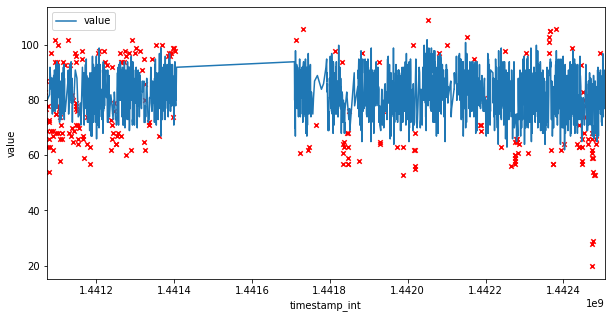

In [13]:
data_nor = data_pre[data_pre.normal == 1]
data_abn = data_pre[data_pre.normal == -1]

ax = plt.gca()
data_nor.plot(x='timestamp_int', y='value', ax=ax, figsize=(15,10))
data_abn.plot(kind='scatter', x='timestamp_int', y='value', ax = ax, marker='x', color='r', figsize=(10,5))

plt.show()

# OneclassSVM

In [15]:
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

In [22]:
min_max_scaler = preprocessing.StandardScaler()
data=data_pre.drop(['timestamp'], axis=1)
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * 0.01) 
data = pd.DataFrame(np_scaled)
model.fit(data)

data_pre['anomaly2'] = pd.Series(model.predict(data))
data_pre['anomaly2'] = data_pre['anomaly2'].map( {1: 0, -1: 1} )
print(data_pre['anomaly2'].value_counts())

0    2469
1      31
Name: anomaly2, dtype: int64


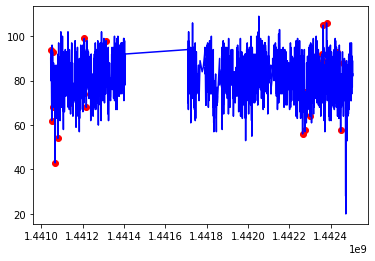

In [24]:
fig, ax = plt.subplots()

a = data_pre.loc[data_pre['anomaly2'] == 1, ['timestamp_int', 'value']] #anomaly

ax.plot(data_pre['timestamp_int'], data_pre['value'], color='blue')
ax.scatter(a['timestamp_int'], a['value'], color='red')
plt.show()

Comparing the above two models, Isolation Forest detect more outliers than one-class SVM.